In [13]:
import json
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
%matplotlib inline

from tripletdim.experiment import hypothesis_test

np.seterr(invalid='raise')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'raise'}

{'font.size': 7.6800000000000015,
 'axes.labelsize': 7.6800000000000015,
 'axes.titlesize': 7.6800000000000015,
 'xtick.labelsize': 7.040000000000001,
 'ytick.labelsize': 7.040000000000001,
 'legend.fontsize': 7.040000000000001,
 'axes.linewidth': 1.0,
 'grid.linewidth': 0.8,
 'lines.linewidth': 1.2000000000000002,
 'lines.markersize': 4.800000000000001,
 'patch.linewidth': 0.8,
 'xtick.major.width': 1.0,
 'ytick.major.width': 1.0,
 'xtick.minor.width': 0.8,
 'ytick.minor.width': 0.8,
 'xtick.major.size': 4.800000000000001,
 'ytick.major.size': 4.800000000000001,
 'xtick.minor.size': 3.2,
 'ytick.minor.size': 3.2,
 'legend.title_fontsize': 7.6800000000000015}

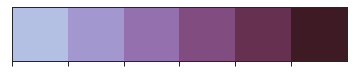

In [14]:
palette = "ch:s=1,r=-.5,l=.75"
sns.set_theme('paper', 'ticks', palette, font_scale=0.8)
cat_palette = quant_palette = palette


sns.palplot(sns.color_palette(palette))
sns.axes_style()
sns.plotting_context()

In [15]:
noise_labels = {0.5: 'low', 1.0: 'med', 2.0: 'high'}
dataset_labels = {
    f'normal-{d}-{n}': f'${d}D$-normal ($n={n}$)'
    for d in (1, 2, 3, 8)
    for n in (20, 60, 100)
}


In [16]:

def load_data(meta_df):
    data_frames = [pd.read_csv(path).assign(data_path=path) for path in meta_df.data_path]
    return pd.concat(data_frames).merge(meta_df, on='data_path', suffixes=(None, '_meta'), how='left', validate='many_to_one')


def read_meta(dir):
    dir = Path(dir)
    meta_paths = list(dir.glob('*.meta.json'))
    data_paths = [path.with_suffix('').with_suffix('.csv') for path in meta_paths]

    meta_dicts = [json.loads(path.read_text()) for path in meta_paths]
    #metas[0]
    meta_df = pd.json_normalize(meta_dicts)
    meta_df['meta_path'] = meta_paths
    meta_df['data_path'] = data_paths
    return meta_df


#pd.read_csv('')
meta = read_meta('../data/embedding/')
meta['data.noise_sd.label'] = meta['data.noise_sd'].map(noise_labels)
meta['data.name.label'] = meta['data.name'].map(dataset_labels)
data = load_data(meta)

#filter = (data['data.name']=="material") & (data.embedding_dimension < 9)
#data = data.drop(data[filter].index)

def apply_ht(score_df):
    try:
        result_dict = hypothesis_test.dimension_hypothesis_test(score_df.dropna(axis='columns', how='all'), alpha=0.05)
        result_df = pd.DataFrame(result_dict)
    except:
        print(score_df)
        print(result_dict)
        raise
    result_df.sort_values(by=['step'], inplace=True)
    result_df['start_dimension'] = start_dim = score_df['embedding_dimension'].min()
    result_df['end_dimension'] = end_dim = score_df['embedding_dimension'].max()
    result_df['dimension'] = result_df['step'] + start_dim
    first_accept = result_df.reject.idxmin()
    if result_df.reject[first_accept] == True:  # for some reason, we need '=='' instead of 'is' here
        result_df['estimated_dimension'] = end_dim
    else:
        result_df['estimated_dimension'] = result_df.loc[first_accept, 'dimension']
    return result_df

hypotest = data.groupby('meta_path').apply(apply_ht)
hypotest = hypotest.merge(meta, on='meta_path', suffixes=(None, '_meta'), how='left', validate='many_to_one').fillna(0)
hypotest['dimension_upper_bound'] = hypotest['step'] + 1

In [17]:
data['id'] = data.index
data_long_train = pd.wide_to_long(data, 'split', i='id', j='split_id', suffix='\\d+_train_score').reset_index()
data_long_train.rename(columns={'split': 'split_train_score'}, inplace=True)
data_long_test = pd.wide_to_long(data, 'split', i='id', j='split_id', suffix='\\d+_test_score').reset_index()
data_long_test.rename(columns={'split': 'split_test_score'}, inplace=True)

In [66]:
def annotate_lines(ys, **kwargs):
    for y in ys.unique():
       plt.axhline(y=y, **kwargs)

def set_ndlogn_title(fg, group):
    for (i, j, k), facet_data in fg.facet_data():
        facet_data = group.loc[facet_data.index]
        title = '  '
        if (i == 0 # share title across rows
            and len(facet_data["data.frac_train_triplets"].unique()) == 1):
            t = facet_data["data.n_train_triplets"].iloc[0]
            if t > 0:
                title += f'#triplets = ${t:.0f}$'
            lambd = facet_data["data.frac_train_ndlogn"].iloc[0]
            if lambd > 0:
                title += f', $\\lambda = {lambd:.0f}$'
        fg.axes[i, j].set_title(title)
        
    
def relplot_score(group, y, ylabel, hue=None, hue_label=None, show_title=True, x_tick_locator=None, height=1.8,
                  reflines=True, move_legend=False, **kwargs):
    group = group.copy()
    if 'hue_order' in kwargs:
        hue_order = kwargs.pop('hue_order')
    else:
        hue_order = sorted(group[hue].unique()) if hue else None
    if 'data.n_train_triplets' not in (hue,y):
        col = 'data.n_train_triplets'
    else:
        col = None
        
    if hue_label is not None:
        group[hue_label] = group[hue]
        hue = hue_label
    fg = sns.relplot(data=group, kind='line', hue=hue, palette=quant_palette,
                     ci='sd', err_style='bars', col=col,
                     x='embedding_dimension', y=y, style=hue, hue_order=hue_order, style_order=hue_order,
                     height=height, **kwargs)


    if fg.legend and move_legend:
        max_dim = fg.data['embedding_dimension'].max()
        y = fg.data[fg.data['embedding_dimension'] == max_dim][y]
        if abs(y.max() - 1) > abs(y.min() - 0.5):
            sns.move_legend(fg, 'upper right', bbox_to_anchor=(1, 0.9), frameon=False, ncol=2)
        else: # lower legend
            sns.move_legend(fg, 'lower right', bbox_to_anchor=(1, 0.22), frameon=False, ncol=2)

    if reflines is True or reflines == 'y':
        fg.map(annotate_lines, 'data.max_train_score', ls='-', zorder=0, color='.8')
    if (reflines is True or reflines == 'x') and (group['data.name'].str.startswith('normal')).all():  # only for simulations
        fg.map(plt.axvline, x=group['data.n_dimension'].iloc[0], ls='-', zorder=0, color='.8')
    
    dataset = group['data.name'].iloc[0]
    if show_title:
        fg.fig.subplots_adjust(top=0.8)
        fg.fig.suptitle(f"Dataset = {dataset}")
    if x_tick_locator is not None:
        for ax in fg.axes.ravel():
            ax.xaxis.set_major_locator(x_tick_locator)
        
    set_ndlogn_title(fg, group)
    fg.set_axis_labels('Scaling dimension', ylabel)
    fg.set(xticks=group['embedding_dimension'].unique(), ylim=(0.5, 1.05))
    fg.tight_layout()
    return fg


def relplot_hypotest(group, y, ylabel, hue=None, hue_label=None, show_title=True, x_tick_locator=None, height=1.8, reflines=True, **kwargs):
    if 'hue_order' in kwargs:
        hue_order = kwargs.pop('hue_order')
    else:
        hue_order = sorted(group[hue].unique()) if hue else None
    n_rows = len(hue_order) if hue else 1

    min_dim = group['dimension_upper_bound'].min()
    max_dim = group['dimension_upper_bound'].max()
    bins = np.arange(min_dim, max_dim + 2)
    # we use the "weights" parameter as a work-around to
    # show our precomputed p-values instead of an actual histogram
    fg = sns.displot(data=group, kind='hist', hue=hue, col='data.n_train_triplets', row=hue, row_order=hue_order,
                     palette=quant_palette, x='dimension_upper_bound', weights=y, hue_order=hue_order,
                     element='bars', bins=bins, aspect=n_rows, height=height/n_rows, **kwargs)
    fg.set_titles(row_template='{row_name}')
    if fg.legend:
        fg.legend.set_title(hue_label)

    if hue == 'data.noise_sd' and reflines:  # is simulation
        dim = group['data.n_dimension'].iloc[0]
        alpha = group['alpha'].iloc[0]
        fg.map(plt.fill_between, x=[1, dim], y1=-1, y2=alpha, zorder=0, color='.9')
        fg.map(plt.fill_between, x=[dim, max_dim + 1], y1=alpha, y2=1.0, zorder=0, color='.9')
        fg.map(plt.axvline, x=group['data.n_dimension'].iloc[0], ls='-', zorder=1, color='.8')

    for (i, j, k), facet_data in fg.facet_data():
        # unfortunately, FacetGrid.facet_data does not really iterate over the hues k
        # we have to do this ourselves
        if hue is None:
            facet_groups = [(None, facet_data)]
        else:
            facet_groups = facet_data.groupby([hue])
        colors = sns.color_palette(cat_palette, n_colors=len(facet_groups))
        for k, (__, facet_group) in enumerate(facet_groups):
            estimated_dimension = group.loc[facet_group.index[0]]['estimated_dimension']
            fg.axes[i, j].axvline(estimated_dimension, color='red', linestyle='-', linewidth=2)  # use same color: colors[k]
    
    dataset = group['data.name'].iloc[0]
    print("show_title", show_title)
    if show_title:
        fg.fig.suptitle(f"Dataset = {dataset}")

    if x_tick_locator is not None:
        for ax in fg.axes.ravel():
            ax.autoscale(False)
            ax.xaxis.set_major_locator(x_tick_locator)
            
    if fg.axes.size > 1:
        set_ndlogn_title(fg, group)

    # workaround for a common ylabel across all rows
    fg.set_axis_labels('Scaling dimension', ' ')
    fg.fig.text(0.01, 0.5, ylabel, va='center', rotation='vertical')
    
    fg.set(xticks=bins, ylim=(0, 1.05))#
    fg.tight_layout(h_pad=-1.0)
    return fg

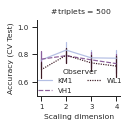

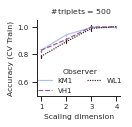

/home/dek/anaconda3/envs/dimensionality/lib/python3.8/site-packages/seaborn/distributions.py:376: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  and estimate_kws["bins"] == "auto"
/home/dek/anaconda3/envs/dimensionality/lib/python3.8/site-packages/seaborn/axisgrid.py:88: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self._figure.tight_layout(*args, **kwargs)


show_title False


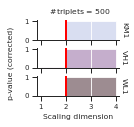

/home/dek/anaconda3/envs/dimensionality/lib/python3.8/site-packages/seaborn/distributions.py:376: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  and estimate_kws["bins"] == "auto"
/home/dek/anaconda3/envs/dimensionality/lib/python3.8/site-packages/seaborn/axisgrid.py:88: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self._figure.tight_layout(*args, **kwargs)


show_title False


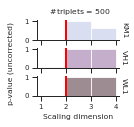

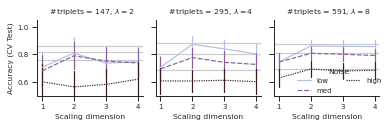

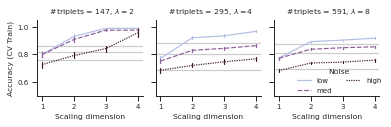

/home/dek/anaconda3/envs/dimensionality/lib/python3.8/site-packages/seaborn/distributions.py:376: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  and estimate_kws["bins"] == "auto"
/home/dek/anaconda3/envs/dimensionality/lib/python3.8/site-packages/seaborn/axisgrid.py:88: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self._figure.tight_layout(*args, **kwargs)


show_title False


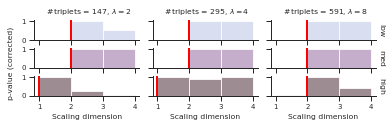

/home/dek/anaconda3/envs/dimensionality/lib/python3.8/site-packages/seaborn/distributions.py:376: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  and estimate_kws["bins"] == "auto"
/home/dek/anaconda3/envs/dimensionality/lib/python3.8/site-packages/seaborn/axisgrid.py:88: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self._figure.tight_layout(*args, **kwargs)


show_title False


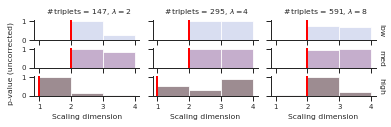

<ipython-input-67-493febe17ebb>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_group['data.n_train_triplets'] = 6000
<ipython-input-67-493febe17ebb>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hypo_group['data.n_train_triplets'] = 6000


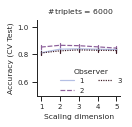

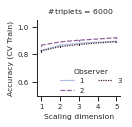

/home/dek/anaconda3/envs/dimensionality/lib/python3.8/site-packages/seaborn/distributions.py:376: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  and estimate_kws["bins"] == "auto"
/home/dek/anaconda3/envs/dimensionality/lib/python3.8/site-packages/seaborn/axisgrid.py:88: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self._figure.tight_layout(*args, **kwargs)


show_title False


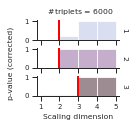

/home/dek/anaconda3/envs/dimensionality/lib/python3.8/site-packages/seaborn/distributions.py:376: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  and estimate_kws["bins"] == "auto"
/home/dek/anaconda3/envs/dimensionality/lib/python3.8/site-packages/seaborn/axisgrid.py:88: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self._figure.tight_layout(*args, **kwargs)


show_title False


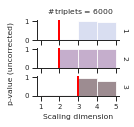

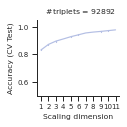

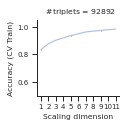

/home/dek/anaconda3/envs/dimensionality/lib/python3.8/site-packages/seaborn/distributions.py:376: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  and estimate_kws["bins"] == "auto"


show_title False


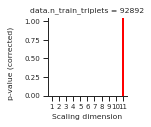

/home/dek/anaconda3/envs/dimensionality/lib/python3.8/site-packages/seaborn/distributions.py:376: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  and estimate_kws["bins"] == "auto"


show_title False


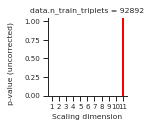

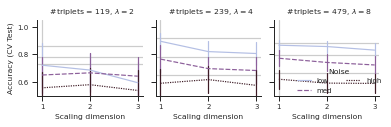

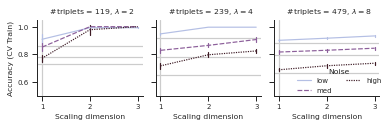

/home/dek/anaconda3/envs/dimensionality/lib/python3.8/site-packages/seaborn/distributions.py:376: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  and estimate_kws["bins"] == "auto"
/home/dek/anaconda3/envs/dimensionality/lib/python3.8/site-packages/seaborn/axisgrid.py:88: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self._figure.tight_layout(*args, **kwargs)


show_title False


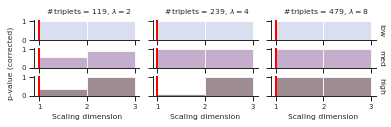

/home/dek/anaconda3/envs/dimensionality/lib/python3.8/site-packages/seaborn/distributions.py:376: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  and estimate_kws["bins"] == "auto"
/home/dek/anaconda3/envs/dimensionality/lib/python3.8/site-packages/seaborn/axisgrid.py:88: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self._figure.tight_layout(*args, **kwargs)


show_title False


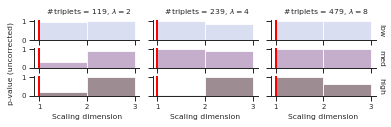

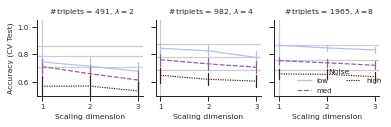

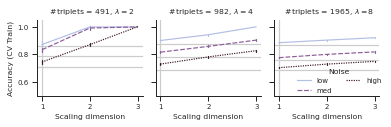

/home/dek/anaconda3/envs/dimensionality/lib/python3.8/site-packages/seaborn/distributions.py:376: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  and estimate_kws["bins"] == "auto"
/home/dek/anaconda3/envs/dimensionality/lib/python3.8/site-packages/seaborn/axisgrid.py:88: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self._figure.tight_layout(*args, **kwargs)


show_title False


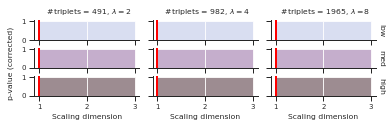

/home/dek/anaconda3/envs/dimensionality/lib/python3.8/site-packages/seaborn/distributions.py:376: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  and estimate_kws["bins"] == "auto"
/home/dek/anaconda3/envs/dimensionality/lib/python3.8/site-packages/seaborn/axisgrid.py:88: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self._figure.tight_layout(*args, **kwargs)


show_title False


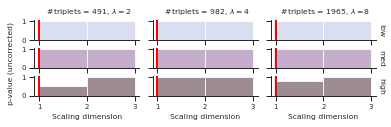

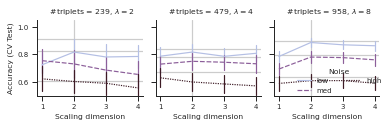

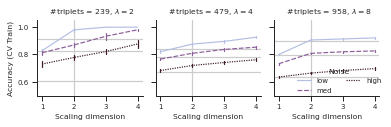

/home/dek/anaconda3/envs/dimensionality/lib/python3.8/site-packages/seaborn/distributions.py:376: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  and estimate_kws["bins"] == "auto"
/home/dek/anaconda3/envs/dimensionality/lib/python3.8/site-packages/seaborn/axisgrid.py:88: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self._figure.tight_layout(*args, **kwargs)


show_title False


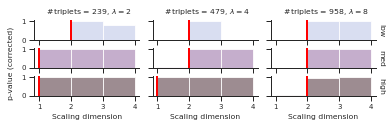

/home/dek/anaconda3/envs/dimensionality/lib/python3.8/site-packages/seaborn/distributions.py:376: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  and estimate_kws["bins"] == "auto"
/home/dek/anaconda3/envs/dimensionality/lib/python3.8/site-packages/seaborn/axisgrid.py:88: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self._figure.tight_layout(*args, **kwargs)


show_title False


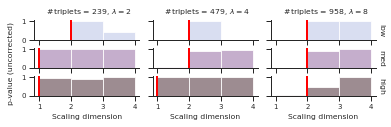

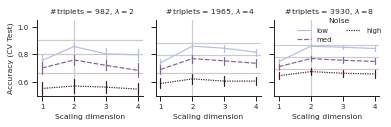

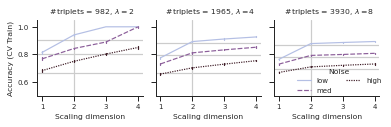

/home/dek/anaconda3/envs/dimensionality/lib/python3.8/site-packages/seaborn/distributions.py:376: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  and estimate_kws["bins"] == "auto"
/home/dek/anaconda3/envs/dimensionality/lib/python3.8/site-packages/seaborn/axisgrid.py:88: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self._figure.tight_layout(*args, **kwargs)


show_title False


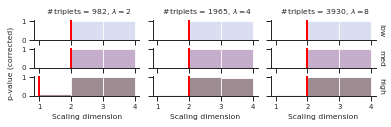

/home/dek/anaconda3/envs/dimensionality/lib/python3.8/site-packages/seaborn/distributions.py:376: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  and estimate_kws["bins"] == "auto"
/home/dek/anaconda3/envs/dimensionality/lib/python3.8/site-packages/seaborn/axisgrid.py:88: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self._figure.tight_layout(*args, **kwargs)


show_title False


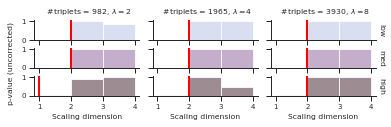

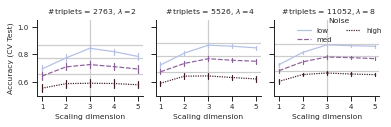

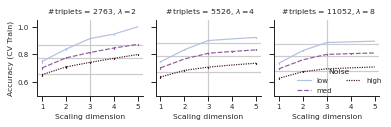

/home/dek/anaconda3/envs/dimensionality/lib/python3.8/site-packages/seaborn/distributions.py:376: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  and estimate_kws["bins"] == "auto"
/home/dek/anaconda3/envs/dimensionality/lib/python3.8/site-packages/seaborn/axisgrid.py:88: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self._figure.tight_layout(*args, **kwargs)


show_title False


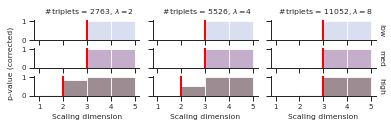

/home/dek/anaconda3/envs/dimensionality/lib/python3.8/site-packages/seaborn/distributions.py:376: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  and estimate_kws["bins"] == "auto"
/home/dek/anaconda3/envs/dimensionality/lib/python3.8/site-packages/seaborn/axisgrid.py:88: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self._figure.tight_layout(*args, **kwargs)


show_title False


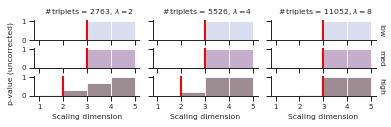

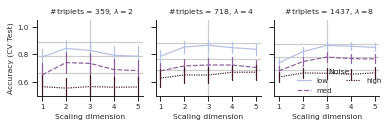

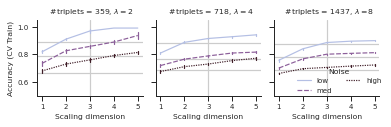

/home/dek/anaconda3/envs/dimensionality/lib/python3.8/site-packages/seaborn/distributions.py:376: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  and estimate_kws["bins"] == "auto"
/home/dek/anaconda3/envs/dimensionality/lib/python3.8/site-packages/seaborn/axisgrid.py:88: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self._figure.tight_layout(*args, **kwargs)


show_title False


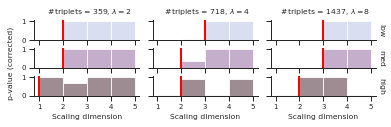

/home/dek/anaconda3/envs/dimensionality/lib/python3.8/site-packages/seaborn/distributions.py:376: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  and estimate_kws["bins"] == "auto"
/home/dek/anaconda3/envs/dimensionality/lib/python3.8/site-packages/seaborn/axisgrid.py:88: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self._figure.tight_layout(*args, **kwargs)


show_title False


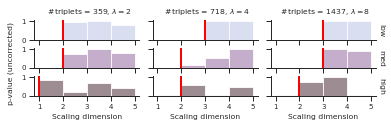

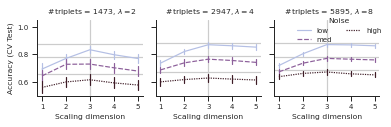

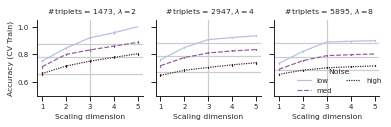

/home/dek/anaconda3/envs/dimensionality/lib/python3.8/site-packages/seaborn/distributions.py:376: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  and estimate_kws["bins"] == "auto"
/home/dek/anaconda3/envs/dimensionality/lib/python3.8/site-packages/seaborn/axisgrid.py:88: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self._figure.tight_layout(*args, **kwargs)


show_title False


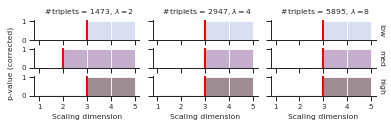

/home/dek/anaconda3/envs/dimensionality/lib/python3.8/site-packages/seaborn/distributions.py:376: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  and estimate_kws["bins"] == "auto"
/home/dek/anaconda3/envs/dimensionality/lib/python3.8/site-packages/seaborn/axisgrid.py:88: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self._figure.tight_layout(*args, **kwargs)


show_title False


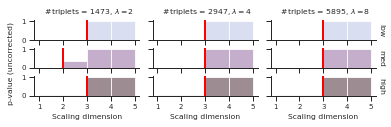

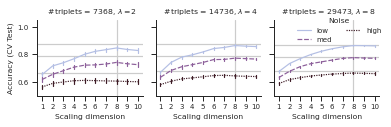

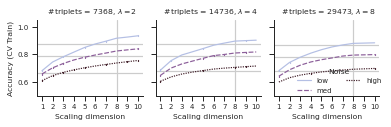

/home/dek/anaconda3/envs/dimensionality/lib/python3.8/site-packages/seaborn/distributions.py:376: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  and estimate_kws["bins"] == "auto"
/home/dek/anaconda3/envs/dimensionality/lib/python3.8/site-packages/seaborn/axisgrid.py:88: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self._figure.tight_layout(*args, **kwargs)


show_title False


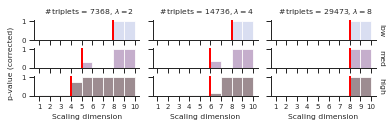

/home/dek/anaconda3/envs/dimensionality/lib/python3.8/site-packages/seaborn/distributions.py:376: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  and estimate_kws["bins"] == "auto"
/home/dek/anaconda3/envs/dimensionality/lib/python3.8/site-packages/seaborn/axisgrid.py:88: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self._figure.tight_layout(*args, **kwargs)


show_title False


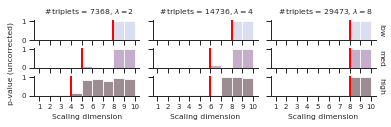

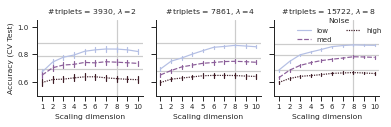

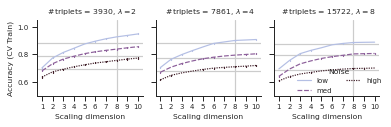

/home/dek/anaconda3/envs/dimensionality/lib/python3.8/site-packages/seaborn/distributions.py:376: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  and estimate_kws["bins"] == "auto"
/home/dek/anaconda3/envs/dimensionality/lib/python3.8/site-packages/seaborn/axisgrid.py:88: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self._figure.tight_layout(*args, **kwargs)


show_title False


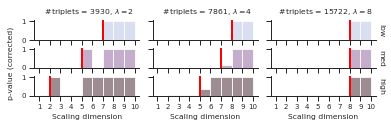

/home/dek/anaconda3/envs/dimensionality/lib/python3.8/site-packages/seaborn/distributions.py:376: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  and estimate_kws["bins"] == "auto"
/home/dek/anaconda3/envs/dimensionality/lib/python3.8/site-packages/seaborn/axisgrid.py:88: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self._figure.tight_layout(*args, **kwargs)


show_title False


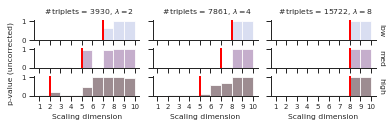

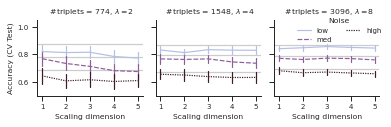

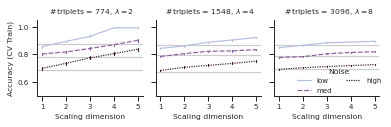

/home/dek/anaconda3/envs/dimensionality/lib/python3.8/site-packages/seaborn/distributions.py:376: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  and estimate_kws["bins"] == "auto"
/home/dek/anaconda3/envs/dimensionality/lib/python3.8/site-packages/seaborn/axisgrid.py:88: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self._figure.tight_layout(*args, **kwargs)


show_title False


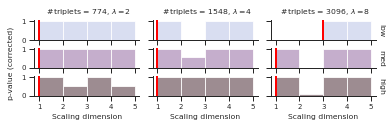

/home/dek/anaconda3/envs/dimensionality/lib/python3.8/site-packages/seaborn/distributions.py:376: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  and estimate_kws["bins"] == "auto"
/home/dek/anaconda3/envs/dimensionality/lib/python3.8/site-packages/seaborn/axisgrid.py:88: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self._figure.tight_layout(*args, **kwargs)


show_title False


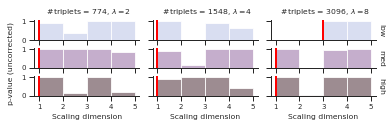

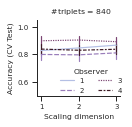

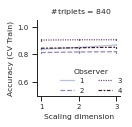

/home/dek/anaconda3/envs/dimensionality/lib/python3.8/site-packages/seaborn/distributions.py:376: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  and estimate_kws["bins"] == "auto"
/home/dek/anaconda3/envs/dimensionality/lib/python3.8/site-packages/seaborn/axisgrid.py:88: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self._figure.tight_layout(*args, **kwargs)


show_title False


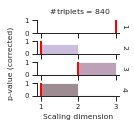

/home/dek/anaconda3/envs/dimensionality/lib/python3.8/site-packages/seaborn/distributions.py:376: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  and estimate_kws["bins"] == "auto"
/home/dek/anaconda3/envs/dimensionality/lib/python3.8/site-packages/seaborn/axisgrid.py:88: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self._figure.tight_layout(*args, **kwargs)


show_title False


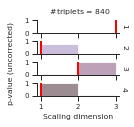

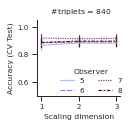

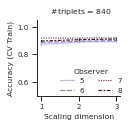

/home/dek/anaconda3/envs/dimensionality/lib/python3.8/site-packages/seaborn/distributions.py:376: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  and estimate_kws["bins"] == "auto"
/home/dek/anaconda3/envs/dimensionality/lib/python3.8/site-packages/seaborn/axisgrid.py:88: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self._figure.tight_layout(*args, **kwargs)


show_title False


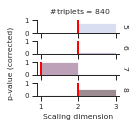

/home/dek/anaconda3/envs/dimensionality/lib/python3.8/site-packages/seaborn/distributions.py:376: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  and estimate_kws["bins"] == "auto"
/home/dek/anaconda3/envs/dimensionality/lib/python3.8/site-packages/seaborn/axisgrid.py:88: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self._figure.tight_layout(*args, **kwargs)


show_title False


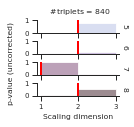

In [67]:
def create_train_test_hypo_plots(query=None, file_suffix=None, save=True, show=True):
    if query:
        test_groups = data_long_test.query(query).groupby(['data.name'])
        train_groups = data_long_train.query(query).groupby(['data.name'])
        hypo_groups = hypotest.query(query).groupby(['data.name'])
    else:
        test_groups = data_long_test.groupby(['data.name'])
        train_groups = data_long_train.groupby(['data.name'])
        hypo_groups = hypotest.groupby(['data.name'])

    for dataset, test_group in test_groups:
        train_group = train_groups.get_group(dataset)
        hypo_group = hypo_groups.get_group(dataset)
        if 'eidolon' == dataset:
            # a few trials were not responded by subject 2 and 3, but for simplicity we show all #trials in the plot
            # THIS DOES NOT CHANGE THE ORIGINAL DATAFRAME, JUST THE GROUP USED IN THIS FUNCTION
            test_group['data.n_train_triplets'] = 6000
            train_group['data.n_train_triplets'] = 6000
            hypo_group['data.n_train_triplets'] = 6000

        # Pass a common tick locator to align the plots.
        kwargs = dict(x_tick_locator=matplotlib.ticker.LinearLocator(len(test_group['embedding_dimension'].unique())), facet_kws=dict(legend_out=False, margin_titles=True), show_title=False)
        if file_suffix:
            suffix = f'{dataset}-{file_suffix}'
        else:
            suffix = f'{dataset}'

        if test_group['data.noise_sd'].nunique() > 1:
            kwargs.update(hue='data.noise_sd.label', hue_label="Noise", hue_order=['low', 'med', 'high'])
        if 'data.subject' in test_group.columns and test_group['data.subject'].nunique() > 1:
            kwargs.update(hue='data.subject', hue_label="Observer")

        fg = relplot_score(test_group, y='split_test_score', ylabel='Accuracy (CV Test)', move_legend=True, **kwargs)
        if save:
            fg.savefig(f'../tex/plots/embedding-cvtest-{suffix}.pdf')
        if show:
            plt.show()

        fg = relplot_score(train_group, y='split_train_score', ylabel='Accuracy (CV Train)', move_legend=True, **kwargs)
        if save:
            fg.savefig(f'../tex/plots/embedding-cvtrain-{suffix}.pdf')
        if show:
            plt.show()

        fg = relplot_hypotest(hypo_group, y='pvals_corrected', ylabel='p-value (corrected)',
                              legend=False, **kwargs)
        if save:
            fg.savefig(f'../tex/plots/hypotest-{suffix}.pdf')
        if show:
            plt.show()

        fg = relplot_hypotest(hypo_group, y='pvals', ylabel='p-value (uncorrected)',
                              legend=False, **kwargs)
        if save:
            fg.savefig(f'../tex/plots/hypotest-{suffix}-uncorrected.pdf')
        if show:
            plt.show()


create_train_test_hypo_plots()

## Reduced accuracy plots "Examples"

Plot separate plots with a single accuracy line each, to introduce the concept.

/home/dek/anaconda3/envs/dimensionality/lib/python3.8/site-packages/seaborn/distributions.py:376: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  and estimate_kws["bins"] == "auto"


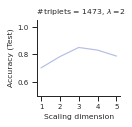

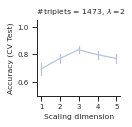

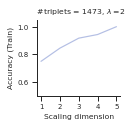

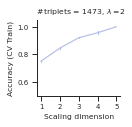

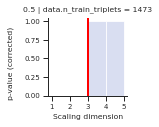

In [23]:
example = '`data.name` == "normal-3-60" and  2-0.1 <= `data.frac_train_ndlogn` <= 2+0.1   and (`data.noise_sd` == 0.0 or `data.noise_sd` == 0.5)'
kwargs = dict(show_title=False, height=1.8, hue='data.noise_sd', reflines=False, legend=False)

fg = relplot_score(data.query(example), y='test_score', ylabel='Accuracy (Test)', **kwargs)
fg.savefig(f'../tex/plots/embedding-test-example.pdf')

fg = relplot_score(data_long_test.query(example), y='split_test_score', ylabel='Accuracy (CV Test)', **kwargs)
fg.savefig(f'../tex/plots/embedding-cvtest-example.pdf')

fg = relplot_score(data_long_train.query(example), y='train_score', ylabel='Accuracy (Train)', **kwargs)
fg.savefig(f'../tex/plots/embedding-train-example.pdf')

fg = relplot_score(data_long_train.query(example), y='split_train_score', ylabel='Accuracy (CV Train)', **kwargs)
fg.savefig(f'../tex/plots/embedding-cvtrain-example.pdf')

fg = relplot_hypotest(hypotest.query(example), y='pvals_corrected', ylabel='p-value (corrected)', **kwargs)
fg.savefig(f'../tex/plots/hypotest-example.pdf')

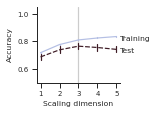

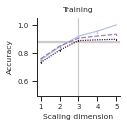

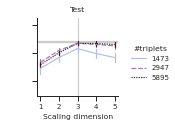

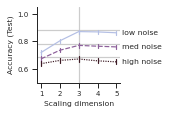

In [126]:
query_high_size = '8-0.1 <= `data.frac_train_ndlogn` <= 8+0.1'
query_med_size = '4-0.1 <= `data.frac_train_ndlogn` <= 4+0.1'

query_med_noise = '(`data.noise_sd` == 1)'
query_low_noise = '(`data.noise_sd` == 0.5)'

query = f'`data.name` == "normal-3-60" and {query_med_size} and {query_med_noise}'
test = data_long_test.query(query).copy().rename(columns={'split_test_score': 'split_score'})
test['Metric'] = 'Test'
train = data_long_train.query(query).copy().rename(columns={'split_train_score': 'split_score'})
train['Metric'] = 'Train'
traintest_df = pd.concat([train, test], axis='rows', ignore_index=True)

kwargs = dict(show_title=False, height=1.8, facet_kws=dict(legend_out=True))

fg = relplot_score(traintest_df, y='split_score', ylabel='Accuracy', hue='Metric', hue_order=['Train', 'Test'], reflines='x', legend=False, **kwargs)
fg.set_titles('')
plt.text(5.2, 0.8,'Training' , va='bottom', ha='left')
plt.text(5.2, 0.75,'Test' , va='top', ha='left')
fg.savefig(f'../tex/plots/embedding-cvtrain-cvtest-example.pdf')

allsize_df = data_long_train.query(f'`data.name` == "normal-3-60" and {query_low_noise}')
fg = relplot_score(allsize_df, y='split_train_score', ylabel='Accuracy', hue='data.n_train_triplets', hue_label='#triplets', reflines=True, legend=False, **kwargs)
plt.title("Training")
fg.savefig(f'../tex/plots/embedding-cvtrain-bytriplets-example.pdf')

allsize_df = data_long_test.query(f'`data.name` == "normal-3-60" and {query_low_noise}')
fg = relplot_score(allsize_df, y='split_test_score', ylabel='   ', hue='data.n_train_triplets', hue_label='#triplets', reflines=True, legend=True, **kwargs)
plt.title("Test")
plt.yticks(color='w')
fg.tight_layout()
fg.savefig(f'../tex/plots/embedding-cvtest-bytriplets-example.pdf')


allnoise_df = data_long_test.query(f'`data.name` == "normal-3-60" and {query_high_size}')
fg = relplot_score(allnoise_df, y='split_test_score', ylabel='Accuracy (Test)', hue='data.noise_sd.label', hue_label='Noise', hue_order=['low', 'med', 'high'], reflines=True, legend=False, **kwargs)
fg.set_titles('')
plt.text(5.3, 0.86,'low noise' , va='center', ha='left')
plt.text(5.3, 0.76,'med noise' , va='center', ha='left')
plt.text(5.3, 0.65,'high noise' , va='center', ha='left')
fg.savefig(f'../tex/plots/embedding-cvtest-bynoise-example.pdf')

<ipython-input-68-cfe382019543>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  normal_hypotest = hypotest[hypotest.estimated_dimension == hypotest.dimension][hypotest['data.name'].str.startswith("normal")].sort_values(by=['data.n_dimension', 'data.n_objects'])
/home/dek/anaconda3/envs/dimensionality/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 66.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/dek/anaconda3/envs/dimensionality/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 33.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/dek/anaconda3/envs/dimensionality/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 55.6% of the points cannot be placed; you may want to decrease the size of the markers or use str

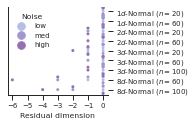

In [68]:
hypotest['relative_estimated_dimension'] = (hypotest.estimated_dimension - hypotest['data.n_dimension']).astype(int)
normal_hypotest = hypotest[hypotest.estimated_dimension == hypotest.dimension][hypotest['data.name'].str.startswith("normal")].sort_values(by=['data.n_dimension', 'data.n_objects'])
normal_hypotest = normal_hypotest[normal_hypotest['data.n_objects'] > 10]
fg = sns.catplot(kind='swarm', data=normal_hypotest, x='relative_estimated_dimension', y='data.name.label', hue='data.noise_sd.label', height=1.8, aspect=1.6, legend_out=False, s=3)
xticks = np.arange(normal_hypotest['relative_estimated_dimension'].min(), normal_hypotest['relative_estimated_dimension'].max() + 1)
fg.set(xticks=xticks)
fg._legend.set_title('Noise')
fg._legend.set_frame_on(False)
(fg.set_xlabels('Residual dimension')
   .set_ylabels('')
  #.refline(x=0, color='r', linestyle='--')
)
fg.ax.yaxis.tick_right()
fg.ax.yaxis.set_label_position("right")
fg.savefig(f'../tex/plots/normal-dimension-offset.pdf')

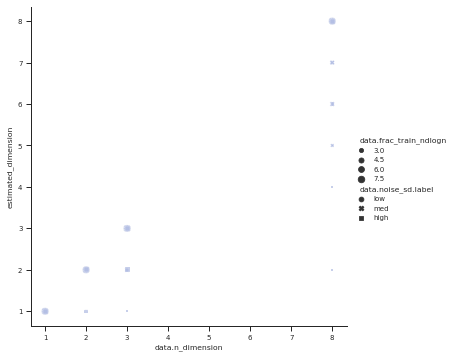

In [80]:
sns.relplot(data=normal_hypotest, x='data.n_dimension', y='estimated_dimension', size='data.frac_train_ndlogn', style='data.noise_sd.label')

In [223]:
low_noise_normal = normal_hypotest[normal_hypotest['data.noise_sd.label'] == 'low']
low_noise_low_dim_normal = low_noise_normal[low_noise_normal['data.n_dimension'] < 5]

print("Dim. accuracy, total", len(normal_hypotest), (normal_hypotest['data.n_dimension'] == normal_hypotest['estimated_dimension']).mean())
print("Dim. accuracy, low noise", len(low_noise_normal), (low_noise_normal['data.n_dimension'] == low_noise_normal['estimated_dimension']).sum())
print("Dim. accuracy, low noise, low dim", len(low_noise_low_dim_normal), (low_noise_low_dim_normal['data.n_dimension'] == low_noise_low_dim_normal['estimated_dimension']).mean())

print("Failing datasets:", low_noise_normal[(low_noise_normal['data.n_dimension'] != low_noise_normal['estimated_dimension'])]['data.name.label'])

Dim. accuracy, total 81 0.7283950617283951
Dim. accuracy, low noise 27 25
Dim. accuracy, low noise, low dim 21 0.9523809523809523
Failing datasets: 224    $3d$-Normal ($n=20$)
418    $8d$-Normal ($n=60$)
Name: data.name.label, dtype: object


## Error of hypothesis tests

In [81]:
hte_meta = pd.concat(read_meta(d) for d in Path('../data/hypotest-error/').glob('*'))
hte_meta['noise_sd.label'] = hte_meta['data.noise_sd'].map(noise_labels)
hte_meta = hte_meta.explode(['correct_reject', 'type1_error', 'type2_error', 'power', 'test_steps']).drop('embedding_dimension', axis=1)
hte_meta

,n_repeats,n_splits,embedding_method,random_state,alpha,data.name,data.n_dimension,data.distance,data.subject,data.n_objects,...,fwer,type1_error,type2_error,power,dataset,n_test_repetition,test_steps,meta_path,data_path,noise_sd.label
0,10,10,soe,4267118511,0.05,normal-3-60,3,euclidean,None,60,...,0,0.0,0.0,1.0,normal-3-60,100,1,../data/hypotest-error/normal-3-60/nois_10-tri...,../data/hypotest-error/normal-3-60/nois_10-tri...,med
0,10,10,soe,4267118511,0.05,normal-3-60,3,euclidean,None,60,...,0,0.0,0.0,1.0,normal-3-60,100,2,../data/hypotest-error/normal-3-60/nois_10-tri...,../data/hypotest-error/normal-3-60/nois_10-tri...,med
0,10,10,soe,4267118511,0.05,normal-3-60,3,euclidean,None,60,...,0,0.0,0.0,1.0,normal-3-60,100,3,../data/hypotest-error/normal-3-60/nois_10-tri...,../data/hypotest-error/normal-3-60/nois_10-tri...,med
0,10,10,soe,4267118511,0.05,normal-3-60,3,euclidean,None,60,...,0,0.0,0.0,1.0,normal-3-60,100,4,../data/hypotest-error/normal-3-60/nois_10-tri...,../data/hypotest-error/normal-3-60/nois_10-tri...,med
1,10,10,soe,1852399244,0.05,normal-3-60,3,euclidean,None,60,...,1,0.0,0.0,1.0,normal-3-60,100,1,../data/hypotest-error/normal-3-60/nois_20-tri...,../data/hypotest-error/normal-3-60/nois_20-tri...,high
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6,10,10,soe,3837146471,0.05,normal-1-20,1,euclidean,None,20,...,1,0.01,0.0,1.0,normal-1-20,100,2,../data/hypotest-error/normal-1-20/nois_10-tri...,../data/hypotest-error/normal-1-20/nois_10-tri...,med
7,10,10,soe,1314499435,0.05,normal-1-20,1,euclidean,None,20,...,0,0.0,0.0,1.0,normal-1-20,100,1,../data/hypotest-error/normal-1-20/nois_05-tri...,../data/hypotest-error/normal-1-20/nois_05-tri...,low
7,10,10,soe,1314499435,0.05,normal-1-20,1,euclidean,None,20,...,0,0.0,0.0,1.0,normal-1-20,100,2,../data/hypotest-error/normal-1-20/nois_05-tri...,../data/hypotest-error/normal-1-20/nois_05-tri...,low
8,10,10,soe,2664404336,0.05,normal-1-20,1,euclidean,None,20,...,2,0.02,0.0,1.0,normal-1-20,100,1,../data/hypotest-error/normal-1-20/nois_10-tri...,../data/hypotest-error/normal-1-20/nois_10-tri...,med


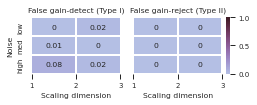

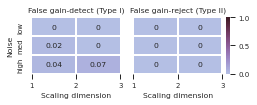

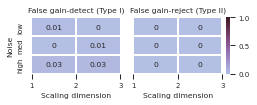

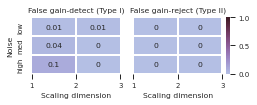

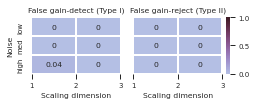

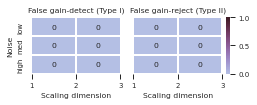

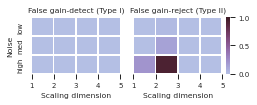

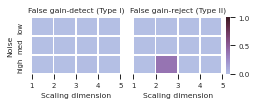

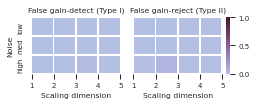

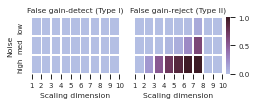

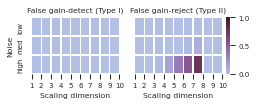

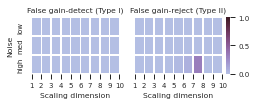

In [119]:
def colorbar(mappable, axis=None):
    """ Add colorbar, that resizes the plot correctly
        
        Modified function from:
        https://joseph-long.com/writing/colorbars/  
    """
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    import matplotlib.pyplot as plt
    last_axes = plt.gca()
    fig = plt.gcf()
    for ax in axis:
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        cbar = plt.gcf().colorbar(mappable, cax=cax)
        if ax != mappable.axes:
            fig.delaxes(fig.axes[-1])
        
    #Create and remove the colorbar for the first subplot
    #fig.delaxes(fig.axes[2])
    
    plt.sca(last_axes)
    return cbar



for (dataset, n_triplets), group in hte_meta.groupby(['dataset', 'data.n_train_triplets']):
    hte_square = group.pivot(index='data.noise_sd', columns='test_steps')
    fig, axis = plt.subplots(1, 2, sharey=True, figsize=(3.6, 1.5))
    #cbar_ax = fig.add_axes([.91, .3, .03, .4])
    annot = hte_square['type1_error'].shape[1] < 3
    ax1 = sns.heatmap(data=hte_square['type1_error'].astype(float), annot=annot, cmap=sns.color_palette(quant_palette, as_cmap=True),
                      cbar=False, vmin=0, vmax=1, square=False, linewidths=.5,ax=axis[0])
    ax2 = sns.heatmap(data=hte_square['type2_error'].astype(float), cmap=sns.color_palette(quant_palette, as_cmap=True),
                      annot=annot, vmin=0, vmax=1, square=False, linewidths=.5, ax=axis[1], cbar=False)
    
    # Move ticks left and right for consistenty with other plots
    xticks = np.arange(len(hte_square['type1_error'].columns) + 1)
    axis[0].set_xticks(ticks=xticks)
    axis[0].set_xticklabels(labels=xticks + 1)
    axis[1].set_xticks(ticks=xticks)
    axis[1].set_xticklabels(labels=xticks + 1)
    axis[0].tick_params(left=False) 
    axis[1].tick_params(left=False) 

    axis[0].set_ylabel('Noise')
    axis[0].set_xlabel('Scaling dimension')
    axis[0].set_title(f"False gain-detect (Type I)")
    axis[0].set_yticklabels(noise_labels[float(t.get_text())] for t in axis[0].get_yticklabels())
    axis[1].set_ylabel('')
    axis[1].set_xlabel('Scaling dimension')
    axis[1].set_title('False gain-reject (Type II)')
    cb = colorbar(axis[1].get_children()[0], axis=axis.ravel().tolist())
    cb.outline.set_linewidth(0)
    fig.tight_layout()

    fig.savefig(f'../tex/plots/hypotest-error-{dataset}-{n_triplets}.pdf')
    plt.show()